<img src = "https://drive.google.com/uc?export=view&id=1FSCcyEY8_AsxSOTiv88txhmxbUwfLw_P" alt = "Encabezado MLDS" width = "100%">  </img>

#**Quiz 9: *Geopandas* (OPCIONAL - No calificable)**
---

Este es un quiz para practicar las habilidades adquiridas usando *GeoPandas*  para trabajar con datos geoespaciales y construir mapas coropléticos estáticos.

> **Nota:** Esta tarea **NO** es calificable y su realización es completamente opcional.

# **Estratificación en Bogotá D.C.**
___

La estratificación permite clasificar a la población en diferentes grupos socioeconómicos. La estratificación define elementos como los subsidios que asigna el gobierno para el cobro de los servicios públicos domiciliarios. Aquellas personas que viven en domicilios de estrato alto pagan más por los servicios públicos, contribuyendo a los hogares de estrato bajo. Sin embargo, la estratificación también está determinada por las condiciones de acceso y movilidad del domicilio. 

Durante este ejercicio, vamos a visualizar algunos mapas coropléticos analizando la información de los estratos en la ciudad de Bogotá.

## **1. Instalación e importación de librerías**
---
Inicialmente debemos instalar *Geopandas* y sus dependencias:

In [ ]:
# GeoPandas.
!pip install geopandas

# Dependencias necesarias.
!pip install -U rtree mapclassify fiona pyproj
!sudo apt install libspatialindex-dev

Antes de empezar, tenemos que importar las librerías habituales *Numpy*, *Matplotlib* y *Pandas*, además de las librerías *GeoPandas* y *Shapely*.

In [ ]:
# NumPy, Pandas y Matplotlib.
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# GeoPandas y Shapely.
import geopandas as gpd
import shapely
from shapely.geometry import *    # Herramientas para manipulación geométrica

# Configuraciones adicionales.
import IPython.display as display
%matplotlib inline

Para conocer las versiones de todas las librerías instaladas puede descomentar y ejecutar el siguiente comando:


In [ ]:
# Versiones de Python y demás librerías utilizadas.
!python --version
print('GeoPandas', gpd.__version__)
print('Shapely', shapely.__version__)
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)

Este material se realizó con las siguientes versiones:
* *Python*: 3.7.10
* *GeoPandas*: 0.9.0
* *Shapely*: 1.7.1
* *NumPy*:  1.19.5
* *Pandas*:  1.1.5
* *Matplotlib*:  3.2.2

## **2. Carga de datos**
---

Vamos a usar los siguientes archivos:
- [**`bogota_estratos_2013.json`**](https://drive.google.com/uc?id=1Kpx4vZlEjenn-6AKhH-Nkf9ncVs6NaaL) (**102 MB**): Contiene los polígonos correspondientes a las manzanas del mapa de  Bogotá D.C., además de los estratos de cada sector y la fecha en que se realizó la estratificación.
- [**`bogota_localidades.geojson`**](https://drive.google.com/uc?id=1gtpafjDOLEC1qsRDhxGTsL_7WpivDfzg) (**2.4 MB**): Contiene la información geográfica de las 20 localidades del Distrito Capital de Colombia. Cada localidad agrupa varios barrios y, por supuesto, muchas manzanas de la ciudad.
 
Ejecute la siguiente celda para descargar los datos, la ejecución podría tomar unos minutos por el tamaño de los archivos:


> **Nota**: La ejecución de la celda puede tardar unos minutos.

In [ ]:
# Cargar archivos de datos de estratificación de Bogotá.
!pip install gdown
!gdown https://drive.google.com/uc?id=1Kpx4vZlEjenn-6AKhH-Nkf9ncVs6NaaL
!gdown https://drive.google.com/uc?id=1gtpafjDOLEC1qsRDhxGTsL_7WpivDfzg

### **2.1. Estratos** 
---
Este ejercicio supone un reto adicional, puesto que el JSON que contiene la información, no viene en un formato de carga directa a *GeoPandas*. Primero, cargaremos el archivo en formato JSON en un DataFrame de *pandas* e inspeccionaremos los datos.

In [ ]:
estratos = pd.read_json('bogota_estratos_2013.json')
estratos.head()

Los datos de interés se encuentran dentro de la columna **`fields`**. Veamos un ejemplo:

In [ ]:
estratos['fields'][10]

**Preparación de los datos**
***
Para definir un *GeoDataFrame*, cada fila debe tener mínimo una columna que se llame **`geometry`** y un sistema de coordenadas de referencia. El siguiente código recorre cada una de las filas del *dataset* y guarda en las listas **`geometry`** y **`values`** los datos que nos interesan.

In [ ]:
geometry = []
values = []

for idx, row_value in estratos.iterrows():

    # Ignoramos los registros sin información geográfica.
    if row_value['fields'].get('geo_shape', 0) == 0:
        continue
    
    # Añadimos a la geometría los campos de tipo Polygon.
    if row_value['fields']['geo_shape']['type'] == 'Polygon':
        geometry.append(Polygon([[x, y] for x, y in row_value['fields']['geo_shape']['coordinates'][0]]))

    # Consideramos el caso de objetos MultiPolygon.
    else:
        multipol = []
        for poly in row_value['fields']['geo_shape']['coordinates'][0]:
            multipol.append(Polygon([[x, y] for x, y in poly]))
        geometry.append(MultiPolygon(multipol))
    

    # Añadimos los demás atributos al arreglo de valores.
    values.append([row_value['fields']['objectid'],
                   row_value['fields']['codigo_manzana'], 
                   row_value['fields']['shape_area'],
                   row_value['fields']['shape_len'],
                   row_value['fields']['estrato']])

Creamos un DataFrame de Pandas a partir de la lista **`values`** y renombramos sus columnas:

In [ ]:
df_campos = pd.DataFrame(values, columns=['id', 'manzana', 'shape_area', 'shape_len', 'estrato'])
df_campos.head()

Finalmente, construimos el *GeoDataFrame*:

In [ ]:
estratos = gpd.GeoDataFrame(df_campos, crs='EPSG:4326', geometry=geometry)
estratos = estratos.to_crs(crs='EPSG:4326')

> **Nota**: En la celda anterior, *CRS* se refiere al Sistema de Coordenadas de Referencia (por sus siglas en inglés). Este sistema nos indica cómo se proyectará la información geométrica de las *GeoSeries* o *GeoDataFrames* como lugares en la Tierra. Para más información haga clic **[aquí](https://geopandas.org/projections.html)**.

In [ ]:
estratos.head()

### **2.2. Localidades** 
---
En este caso el archivo está en el formato adecuado para *GeoPandas* por lo que podremos cargarlo directamente a un *GeoDataFrame*:

In [ ]:
localidades = gpd.read_file('bogota_localidades.geojson')

Primero, seleccionaremos únicamente algunas columnas de interés:

In [ ]:
localidades = localidades.loc[:,['CODIGO_LOC', 'NOMBRE', 'geometry']]
localidades.head()

Vamos a filtrar la localidad de **`Sumapaz`** por tratarse de una zona rural:

In [ ]:
localidades = localidades.loc[localidades['CODIGO_LOC'] != '20'] # Filtramos a la localidad Sumapaz por medio del código de la localidad.

Podemos inspeccionar las geometrías de cada localidad. Por ejemplo, con la localidad de Teusaquillo:

In [ ]:
localidades.loc[localidades['NOMBRE']=='TEUSAQUILLO','geometry'].plot();

Ahora visualicemos el mapa de todas las localidades:

In [ ]:
# Creamos la figura y el objeto axes
fig, ax = plt.subplots(1, figsize=(15, 10), dpi=300)

# Preparamos la gráfica.
ax.set_title(u'Localidades en Bogotá') 
ax.axis('off')
plt.axis('equal');

# Gráficamos toda la geometría sin color de fondo.
localidades.plot(color='None',
                 edgecolor='black', 
                 linewidth=0.7, 
                 ax=ax);

## **3. Ejercicios**
___


### **3.1. Mapa de estratos por manzana**
---
Genere un mapa coroplético de Bogotá usando la columna de **`estrato`** como categoría a partir del *GeoDataFrame* llamado **`estratos`**.

> **IMPORTANTE**: Al llamar a la función **`plot`** deberá pasar como parámetro **`categorical = True`** para informarle a *GeoPandas* que la variable para construir el mapa coroplético es de tipo categórico.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

* Utilice la función de visualización **`plot`** de *GeoPandas* para generar la visualización.
* Indique mediante los argumentos **`column`** y **`categorical`** que se debe realizar una codificación a partir del valor del **estrato**.
* Puede pasar como argumento (**`ax`**) el objeto *Axes* generado al principio de la celda.
* Puede ser necesario habilitar la leyenda para reproducir la imagen de referencia por completo.

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 10), dpi=300)
ax.set_title(u'Estratos en Bogotá')

### ESCRIBA SU CÓDIGO AQUÍ ### (~ 1 línea de código)


### FIN DEL CÓDIGO

ax.set_axis_off()
plt.axis('equal');

**Salida esperada**:

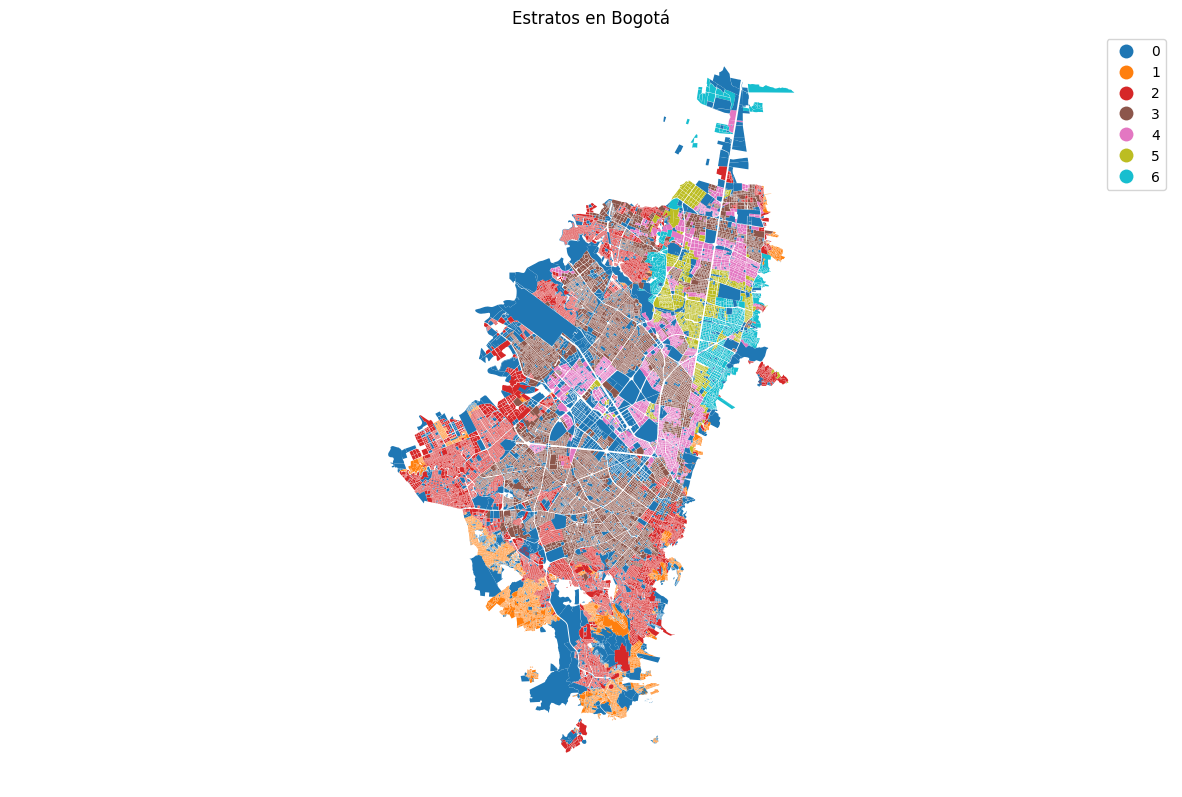



### **3.2. Localidades en Bogotá**
---

Visualice el mapa de las localidades de Bogotá usando el *GeoDataFrame* llamado **`localidades`**. A diferencia del ejemplo presentado anteriormente, esta vez debe anotar el nombre de cada localidad dentro del mapa.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

* Utilice la función de visualización **`plot`** de *GeoPandas* para generar la visualización.
* Recuerde que puede poner anotaciones de texto dentro de los objetos de *Matplotlib* con el método **`ax.text`**.
* Puede iterar por cada localidad (usando el método **`iterrows`** o similares) y añadir las etiquetas de manera secuencial.
* Ubique cada etiqueta en un punto representativo de la geometría de las localidades (atributo **`representative_point`**).
* El estilo de las etiquetas es generado con el argumento **`bbox`** del método **`ax.text`**. Para la imagen de referencia se usó el siguiente diccionario:
```python
dict(boxstyle='round', facecolor='linen', alpha=1)
```

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 10), dpi=300)
ax.set_title(u'Localidades en Bogotá con nombre')

### ESCRIBA SU CÓDIGO AQUÍ ### (~ >= 4 líneas de código)



### FIN DEL CÓDIGO

ax.set_axis_off()
plt.axis('equal');

**Salida esperada**:

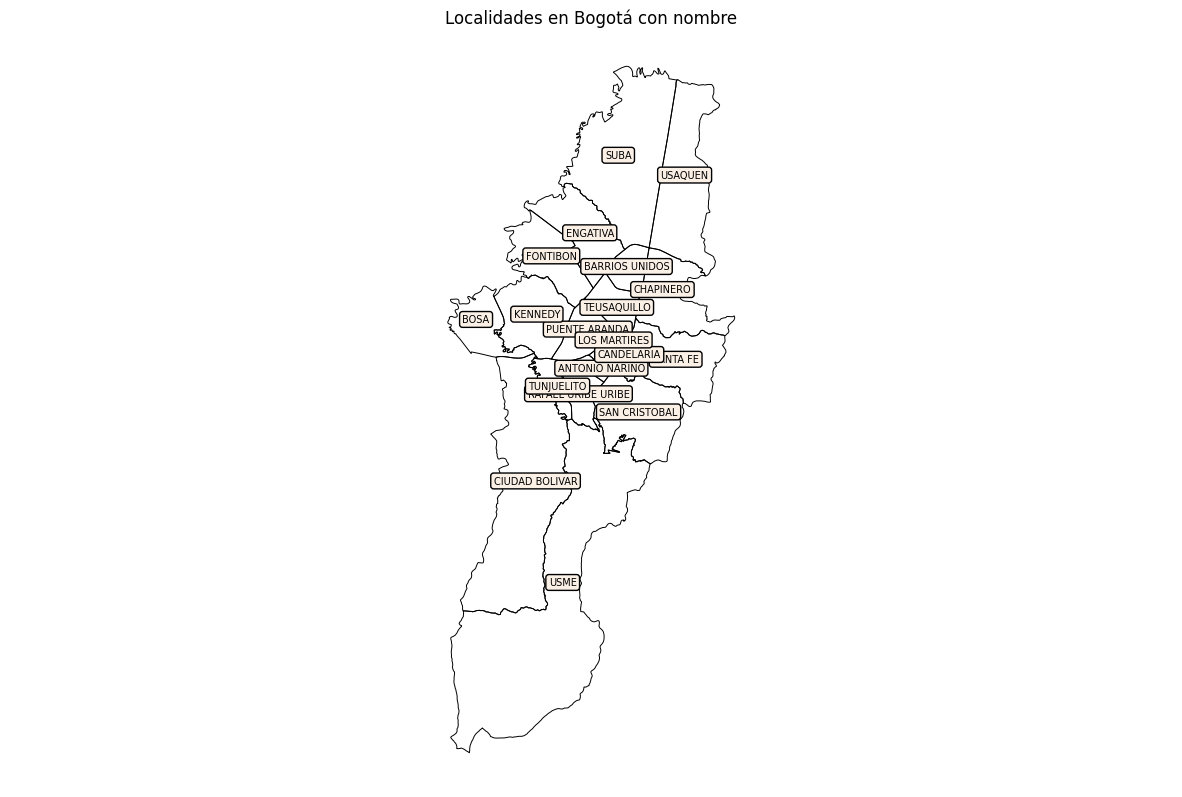


### **3.3. Estratos en una localidad específica**
---

Por último, queremos visualizar un mapa coroplético de toda Bogotá resaltando los estratos como en el *ejercicio 1*. Sin embargo, en este caso el mapa debe mostrar los colores de los estratos únicamente para una localidad específica.

#### **3.3.1. Combinación de *GeoDataFrames***
---

Por un lado, la información de los estratos sociales se encuentra en el *geodataframe* **`estratos`** a nivel de manzanas. Por otra parte, la información de las localidades se encuentra en el *GeoDataFrame* **`localidades`**, donde no se cuenta con los datos de los estratos. Además, estos conjuntos de datos no tienen información en común adicional a los datos geoespaciales. Por lo tanto, debe hacer una combinación de los conjuntos de datos a nivel espacial (**`spatial join`**), entre los **`estratos`** y las **`localidades`**. El *GeoDataFrame* resultante debe llamarse **`estratos_localidades`**.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

* Utilice la función de combinación espacial **`gpd.sjoin`**. 
* Obtenga el *GeoDataFrame* mediante la intersección con respecto de la operación de contención (**`within`**).

In [ ]:
### ESCRIBA SU CÓDIGO AQUÍ ### (~ 1 línea de código)
estratos_localidades = None
### FIN DEL CÓDIGO ###

In [ ]:
# CELDA DE PRUEBAS (NO MODIFICAR)
estratos_localidades.iloc[0]['geometry']

**Salida esperada**:

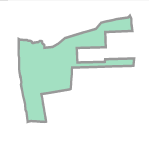

#### **3.3.2. Mapa coroplético**
---
Visualice los estratos de las manzanas que pertenecen a una sola localidad en el mapa de Bogotá. La localidad debe seleccionarse a partir de la siguiente lista:

In [ ]:
list(localidades['NOMBRE'].unique())

Utilice la variable **`localidad_seleccionada`** para graficar únicamente esa localidad. Por ejemplo, con la localidad de Suba:

In [ ]:
localidad_seleccionada = 'SUBA'

Primero, seleccionamos en un nuevo *GeoDataFrame* los datos de la localidad seleccionada a partir del *GeoDataFrame* **`estratos_localidades`**.

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

* Utilice selección condicional sobre el objeto **`estratos_localidades`** usando la variable **`'NOMBRE'`** para distinguir la localidad deseada. 

In [ ]:
### ESCRIBA SU CÓDIGO AQUÍ ### (~ 4 líneas de código)
seleccionada = None
### FIN DEL CÓDIGO ###

In [ ]:
# CELDA DE PRUEBAS (NO MODIFICAR)
# Para el caso de SUBA:

seleccionada[['NOMBRE', 'id', 'manzana', 'estrato']].head()

**Salida esperada**:

|     | NOMBRE   |   id |   manzana |   estrato |
|----:|:---------|-----:|----------:|----------:|
| 113 | SUBA     | 4752 |  00911177 |         0 |
| 120 | SUBA     | 4732 |  00911815 |         5 |
| 133 | SUBA     | 4785 |  00911814 |         5 |
| 134 | SUBA     | 4796 |  00911804 |         5 |
| 790 | SUBA     | 1771 |  00920974 |         2 |

Construya el mapa coroplético requerido. 
> Para los colores de los estratos de la localidad seleccionada use el **`cmap = 'viridis'`**:

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Pistas</b></font>
</summary>

* Utilice la función de visualización **`plot`** de *GeoPandas* para generar las dos visualizaciones. Asegúrese de utilizar el mismo objeto *Axes* y de dibujar el contorno de todos los estratos (sin relleno).
* Indique mediante los argumentos **`column`** y **`categorical`** que se debe realizar una codificación a partir del valor del **estrato** para la localidad seleccionada.
* La imagen de referencia fue generada con líneas de estrato con grosor de $0.05$ y color de línea **`'black'`**.

In [ ]:
fig, ax = plt.subplots(1, figsize=(15, 10), dpi=300)
ax.set_title(u'Localidad de ' + localidad_seleccionada.title())

### ESCRIBA SU CÓDIGO AQUÍ ### (~ 2 líneas de código)




### FIN DEL CÓDIGO ###

ax.set_axis_off()
plt.axis('equal');

**Salida esperada**:

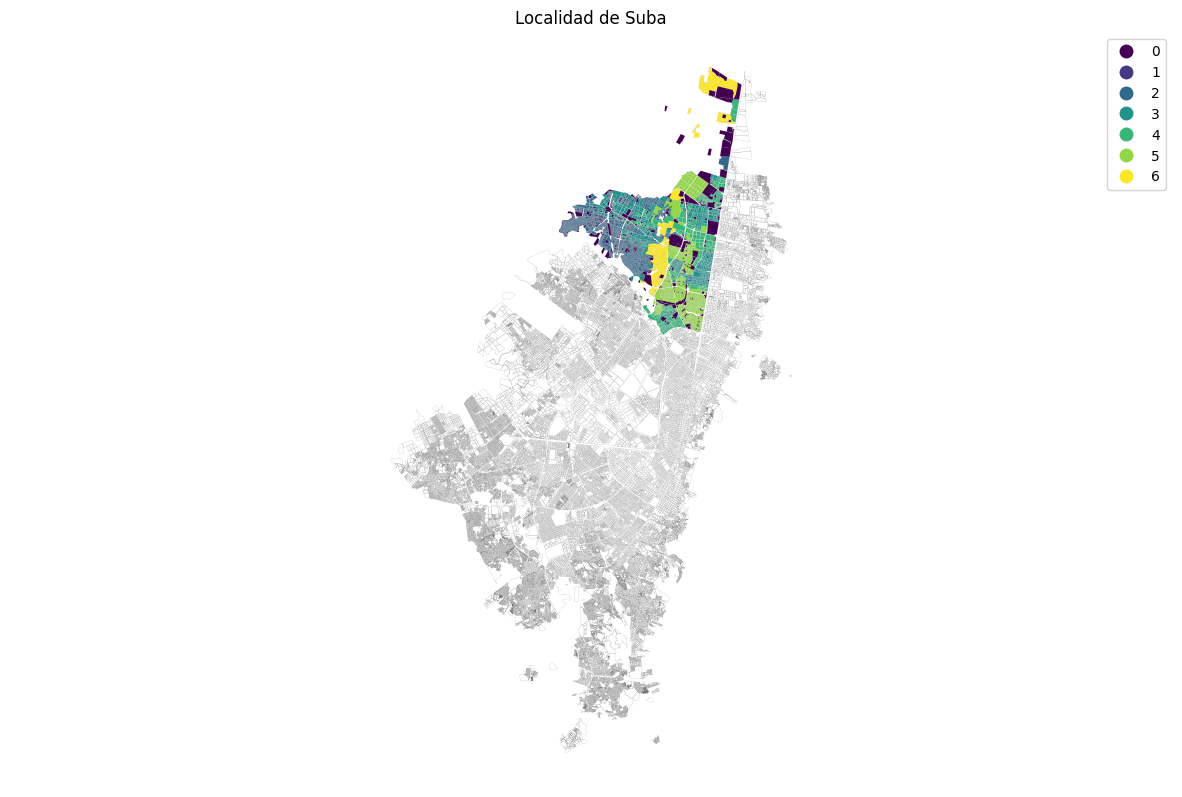

**¡Felicitaciones!** Ha terminado este quiz. ¡Excelente trabajo!

> **Recuerde que este quiz NO requiere entrega - es opcional.**


## **Créditos**
---

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistente docente:** Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*